# 3. Training

In [1]:
import sys
from pathlib import Path
import warnings
import os

warnings.filterwarnings("ignore", module="IPython")

def is_google_colab() -> bool:
    try:
        if "google.colab" in str(get_ipython()):
            return True
    except:
        pass
    return False

def clone_repository() -> None:
    # Check if repository already exists
    repo_dir = Path("pm25-forecast-openmeteo-aqicn")
    if repo_dir.exists():
        print(f"Repository already exists at {repo_dir.absolute()}")
        %cd pm25-forecast-openmeteo-aqicn
    else:
        print("Cloning repository...")
        !git clone https://github.com/KristinaPalmquist/pm25-forecast-openmeteo-aqicn.git
        %cd pm25-forecast-openmeteo-aqicn

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml

def fix_numpy_compatibility():
    print("Fixing numpy compatibility for hopsworks/pandas...")
    try:
        # Use precompiled wheels with compatible versions
        !pip install --force-reinstall numpy==1.24.4 pandas==2.0.3
        print("Numpy and pandas fixed. Please restart runtime and run again.")
    except Exception as e:
        print(f"Fix attempt failed: {e}")
        print("Please manually restart runtime and try again.")

if is_google_colab():
    try:
        import numpy
        numpy.array([1, 2, 3])
        import pandas as pd
        print("Basic packages working correctly")

        clone_repository()
        install_dependencies()

        import hopsworks
        print("All packages working correctly")

        root_dir = str(Path().absolute())
        print("Google Colab environment")
        
    except (ValueError, ImportError) as e:
        if "numpy.dtype size changed" in str(e) or "numpy.strings" in str(e) or "numpy" in str(e).lower():
            fix_numpy_compatibility()
            raise SystemExit("Please restart runtime (Runtime > Restart runtime) and run the notebook again.")
        else:
            raise

else:
    root_dir = Path().absolute()
    if root_dir.parts[-1:] == ("src",):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ("airquality",):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ("notebooks",):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir)
    print("Local environment")

print(f"Root dir: {root_dir}")

if root_dir not in sys.path:
    sys.path.append(root_dir)
    print(f"Added the following directory to the PYTHONPATH: {root_dir}")

from utils import config

if is_google_colab():
    from google.colab import userdata
    import hopsworks
    project = hopsworks.login(
        api_key_value=userdata.get('HOPSWORKS_API_KEY'),
        engine="python"
    )
    AQICN_API_KEY = userdata.get('AQICN_API_KEY')
    
else:
    # Local development - use .env file
    settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Root dir: c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn
Added the following directory to the PYTHONPATH: c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn
HopsworksSettings initialized!


## Imports

In [2]:

from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import hopsworks
from utils import airquality
from collections import defaultdict
import json
import warnings

warnings.filterwarnings("ignore")

## Setup

In [3]:
if is_google_colab():
    fs = project.get_feature_store()
    secrets = hopsworks.get_secrets_api()
else:
    HOPSWORKS_API_KEY = getattr(settings, 'HOPSWORKS_API_KEY', None)

    if HOPSWORKS_API_KEY is not None and hasattr(HOPSWORKS_API_KEY, 'get_secret_value'):
        HOPSWORKS_API_KEY = HOPSWORKS_API_KEY.get_secret_value()

    project = hopsworks.login(engine="python", api_key_value=HOPSWORKS_API_KEY)

    fs = project.get_feature_store()

    secrets = hopsworks.get_secrets_api()
    AQICN_API_KEY = secrets.get_secret("AQICN_API_KEY").value


today = datetime.today().date()

# Retrieve feature groups
air_quality_fg = fs.get_feature_group(
    name="air_quality_all",
    version=1,
)

weather_fg = fs.get_feature_group(
    name="weather_all",
    version=1,
)

2025-11-27 11:11:01,636 INFO: Initializing external client
2025-11-27 11:11:01,636 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-11-27 11:11:03,290 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1279184


Set SENSOR_CSV_FILE in .env with the relative path to a sensor to process it, or leave it unset to process all sensors in the `data` foldertoday = datetime.today().date()

In [4]:
if is_google_colab():
    sensor_csv_file = None
else:
    sensor_csv_file = getattr(settings, 'SENSOR_CSV_FILE', None)

if sensor_csv_file:
    # Read one secret for single sensor mode
    _, _, _, _, _, sensor_id = airquality.read_sensor_data(sensor_csv_file)
    secret_name = f"SENSOR_LOCATION_JSON_{sensor_id}"
    location_str = secrets.get_secret(secret_name).value
    locations = {sensor_id: json.loads(location_str)}
else:
    # Read all individual secrets in batch mode
    all_secrets = secrets.get_secrets()
    locations = {}
    for secret in all_secrets:
        if secret.name.startswith("SENSOR_LOCATION_JSON_"):
            sensor_id = secret.name.replace("SENSOR_LOCATION_JSON_", "")
            location_str = secrets.get_secret(secret.name).value
            if location_str:
                locations[sensor_id] = json.loads(location_str)


## Script

In [5]:
# Select features for training data
baseline_features = air_quality_fg.select(["pm25", "date", "sensor_id"]).join(
    weather_fg.select_features(), on=["sensor_id"]
)

baseline_feature_view = fs.get_or_create_feature_view(
    name="air_quality_baseline_fv",
    description="Weather features for PM2.5 prediction",
    version=1,
    labels=["pm25"],
    query=baseline_features,
)

rolling_features = air_quality_fg.select(["pm25", "pm25_rolling_3d", "date", "sensor_id"]).join(
    weather_fg.select_features(), on=["sensor_id"]
)
rolling_feature_view = fs.get_or_create_feature_view(
    name="air_quality_rolling_fv",
    description="Weather features, PM2.5 rolling window (3d) for PM2.5 prediction",
    version=1,
    labels=["pm25"],
    query=rolling_features,
)

nearby_features = air_quality_fg.select(["pm25", "pm25_nearby_avg", "date", "sensor_id"]).join(
    weather_fg.select_features(), on=["sensor_id"]
)
nearby_feature_view = fs.get_or_create_feature_view(
    name="air_quality_nearby_fv",
    description="Weather features, PM2.5 nearby average (1d lag, 3 sensors) for PM2.5 prediction",
    version=1,
    labels=["pm25"],
    query=nearby_features,
)

lagged_1d_features = air_quality_fg.select(["pm25", "pm25_lag_1d", "date", "sensor_id"]).join(
    weather_fg.select_features(), on=["sensor_id"]
)
lagged_1d_feature_view = fs.get_or_create_feature_view(
    name="air_quality_lagged_1d_fv",
    description="Weather features, PM2.5 lags (1d) for PM2.5 prediction",
    version=1,
    labels=["pm25"],
    query=lagged_1d_features,
)

lagged_2d_features = air_quality_fg.select(["pm25", "pm25_lag_1d", "pm25_lag_2d", "date", "sensor_id"]).join(
    weather_fg.select_features(), on=["sensor_id"]
)
lagged_2d_feature_view = fs.get_or_create_feature_view(
    name="air_quality_lagged_2d_fv",
    description="Weather features, PM2.5 lags (1d, 2d) for PM2.5 prediction",
    version=1,
    labels=["pm25"],
    query=lagged_2d_features,
)

lagged_3d_features = air_quality_fg.select(["pm25", "pm25_lag_1d", "pm25_lag_2d", "pm25_lag_3d", "date", "sensor_id"]).join(
    weather_fg.select_features(), on=["sensor_id"]
)
lagged_3d_feature_view = fs.get_or_create_feature_view(
    name="air_quality_lagged_3d_fv",
    description="Weather features, PM2.5 lags (1d, 2d, 3d) for PM2.5 prediction",
    version=1,
    labels=["pm25"],
    query=lagged_3d_features,
)

complete_features = air_quality_fg.select(["pm25", "pm25_rolling_3d", "pm25_lag_1d", "pm25_lag_2d", "pm25_lag_3d", "pm25_nearby_avg", "date", "sensor_id"]).join(
    weather_fg.select_features(), on=["sensor_id"]
)
complete_feature_view = fs.get_or_create_feature_view(
    name="air_quality_complete_fv",
    description="Weather features, PM2.5 rolling window (3d), and PM2.5 lags (1d, 2d, 3d), and PM2.5 nearby average (1d lag, 3 sensors) for PM2.5 prediction",
    version=1,
    labels=["pm25"],
    query=complete_features,
)

2025-11-27 11:11:09,163 INFO: Using ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant', 'city', 'latitude', 'longitude'] from feature group `weather_all` as features for the query. To include primary key and event time use `select_all`.
2025-11-27 11:11:10,999 INFO: Using ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant', 'city', 'latitude', 'longitude'] from feature group `weather_all` as features for the query. To include primary key and event time use `select_all`.
2025-11-27 11:11:12,732 INFO: Using ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant', 'city', 'latitude', 'longitude'] from feature group `weather_all` as features for the query. To include primary key and event time use `select_all`.
2025-11-27 11:11:14,385 INFO: Using ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant', 'city', 'latitude

In [6]:

start_date_test_data = "2025-05-01"
test_start = datetime.strptime(start_date_test_data, "%Y-%m-%d")

models = defaultdict(dict)
y_preds = defaultdict(dict)
results = []

feature_views = {
    "baseline": baseline_feature_view,
    "rolling": rolling_feature_view,
    "nearby": nearby_feature_view,
    "lagged_1d": lagged_1d_feature_view,
    "lagged_2d": lagged_2d_feature_view,
    "lagged_3d": lagged_3d_feature_view,
    "complete": complete_feature_view,
}

In [7]:
for feature_name, feature_view in feature_views.items():
    data = feature_view.query.read()
    data['date'] = pd.to_datetime(data['date']).dt.tz_localize(None)

    for sensor_id in locations.keys():
        df = data[data['sensor_id'] == sensor_id].copy()
        train_df = df[df['date'] < test_start]
        test_df = df[df['date'] >= test_start]

        # Drop non-feature columns (pm25 is target, others are metadata)
        X_train = train_df.drop(columns=["pm25", "date", "city", "sensor_id"])
        y_train = train_df["pm25"]
        X_test = test_df.drop(columns=["pm25", "date", "city", "sensor_id"])
        y_test = test_df["pm25"]
        
        # run three times and take the best model, save the average of the three
        best_r2 = -float('inf')
        best_mse = float('inf')
        best_model = None
        
        mse_list = []
        r2_list = []
        for i in range(5):
            model = XGBRegressor(n_estimators=100, learning_rate=0.05, random_state=165439*i)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            r2 = r2_score(y_test, y_pred)
            mse = mean_squared_error(y_test, y_pred)
            r2_list.append(r2)
            mse_list.append(mse)
            if r2 > best_r2:
                best_r2 = r2
                best_mse = mse
                best_model = model

        models[feature_name][sensor_id] = best_model
        y_preds[feature_name][sensor_id] = best_model.predict(X_test)

        results.append({
            "feature_name": feature_name,
            "sensor_id": sensor_id,
            "MSE": sum(mse_list) / len(mse_list),
            "R2": sum(r2_list) / len(r2_list),
            "train_size": len(train_df),
            "test_size": len(test_df)
        })

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (3.59s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.80s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.92s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (3.41s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (3.26s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (3.25s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (3.88s) 


In [8]:
model_dir = f"{root_dir}/models"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

In [9]:
# Find best model (highest R2) for each sensor
results_df = pd.DataFrame(results)
best_models = results_df.loc[results_df.groupby('sensor_id')['R2'].idxmax()]
print("Best models per sensor:")
print(best_models[['sensor_id', 'feature_name', 'R2', 'MSE']])

all_data = baseline_features.read()
all_data['date'] = pd.to_datetime(all_data['date']).dt.tz_localize(None)

all_test_data = []
for _, row in best_models.iterrows():
    sensor_id = row['sensor_id']
    best_feature = row['feature_name']
    
    sensor_dir = f"{model_dir}/{sensor_id}"
    if not os.path.exists(sensor_dir):
        os.mkdir(sensor_dir)
    images_dir = f"{model_dir}/{sensor_id}/images"
    if not os.path.exists(images_dir):
        os.mkdir(images_dir)

    best_model = models[best_feature][sensor_id]
    model_path = f"{sensor_dir}/model.json"
    plot_importance(best_model)
    importance_path = f"{images_dir}/feature_importance.png"
    plt.savefig(importance_path)
    plt.close()
    
    best_model.save_model(model_path)

    df = all_data[all_data['sensor_id'] == sensor_id].copy()
    test_df = df[df['date'] >= test_start].copy()
    
    if len(test_df) == 0:
        continue
    
    test_df['predicted_pm25'] = y_preds[best_feature][sensor_id]
    test_df['best_model'] = best_feature
    all_test_data.append(test_df[['date', 'pm25', 'predicted_pm25', 'latitude', 'longitude', 'best_model']])

Best models per sensor:
    sensor_id feature_name        R2        MSE
154    112672     complete  0.162711  26.453351
114    129124    lagged_2d  0.008827   0.283293
100    154549    lagged_2d  0.355392  16.588972
83     180187    lagged_1d -0.433545   0.903478
60     194215       nearby  0.414849  16.521886
67     252352       nearby  0.447568   7.738675
97     404209    lagged_2d  0.277199   2.597018
149    474841     complete  0.415257  14.795073
134     59095    lagged_3d  0.216832   8.387191
30      59893      rolling  0.756278   0.027240
39      60535      rolling -0.004354  16.466617
55      60541       nearby  0.058774  40.407021
140     60853    lagged_3d  0.139824   8.824157
72      61714    lagged_1d  0.063867  16.443576
146     63637     complete  0.438831   3.282334
133     65146    lagged_3d  0.446541   0.101282
141     65272    lagged_3d -4.500951   0.151848
56      69628       nearby  0.076747  27.549950
136     69724    lagged_3d  0.091764  20.589350
166     70564   

In [10]:
# print a table for the model performance for each sensor
for sensor_id, location in locations.items():
    print(f"{sensor_id} with train/test size: {results_df[results_df['sensor_id'] == sensor_id]['train_size'].iloc[0]}/{results_df[results_df['sensor_id'] == sensor_id]['test_size'].iloc[0]}")
    print(results_df[results_df['sensor_id'] == sensor_id][['feature_name', 'R2', 'MSE']])
    print("\n")

61714 with train/test size: 1962/194
    feature_name        R2        MSE
0       baseline -0.017131  17.866327
24       rolling -0.021567  17.944261
48        nearby -0.007435  17.696017
72     lagged_1d  0.063867  16.443576
96     lagged_2d  0.053074  16.633159
120    lagged_3d  0.030458  17.030405
144     complete  0.039887  16.864792


404209 with train/test size: 660/202
    feature_name        R2       MSE
1       baseline -0.280991  4.602589
25       rolling  0.019806  3.521829
49        nearby -0.114880  4.005755
73     lagged_1d  0.272506  2.613880
97     lagged_2d  0.277199  2.597018
121    lagged_3d  0.213062  2.827462
145     complete  0.143817  3.076257


63637 with train/test size: 1908/182
    feature_name        R2       MSE
2       baseline  0.091667  5.312929
26       rolling  0.195804  4.703818
50        nearby  0.406888  3.469171
74     lagged_1d  0.394534  3.541433
98     lagged_2d  0.391433  3.559569
122    lagged_3d  0.432905  3.316995
146     complete  0.438831

Train 5 models with different random seeds, evaluate each on the test set, and select the model with the highest R^2 score.

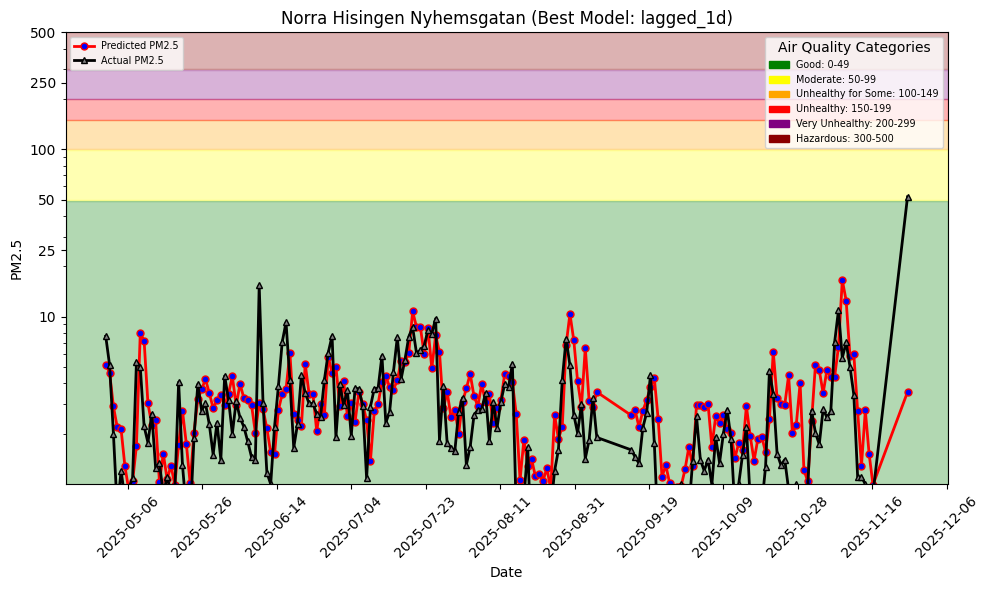

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/61714/model.json: 0.000%|      …

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/61714\images/feature_importance…

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/61714\images/forecast.png: 0.00…

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/61714\images/hindcast_predictio…

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/61714\images/hindcast_training.…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1279184/models/air_quality_xgboost_model_61714/5


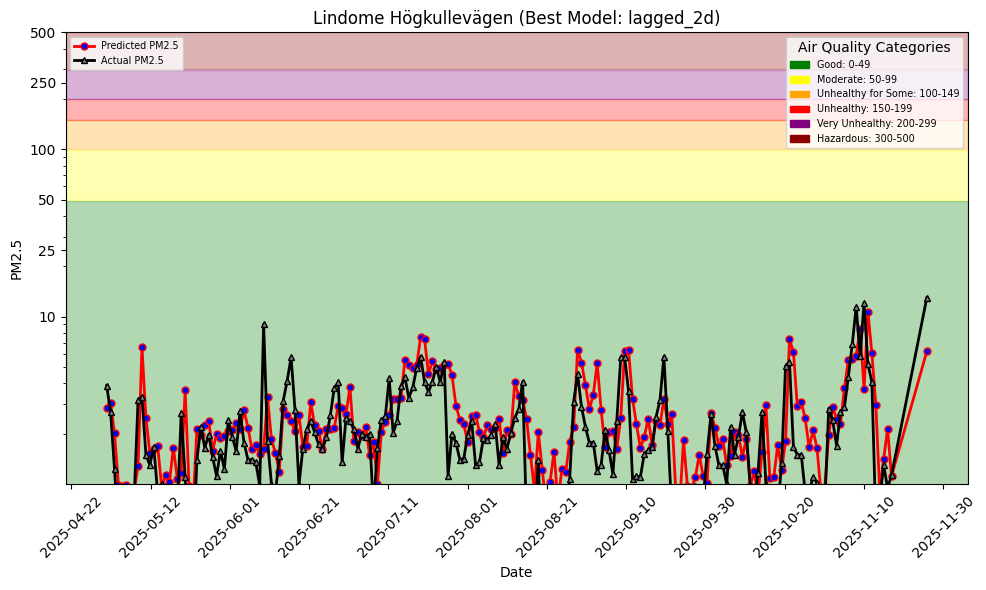

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/404209/model.json: 0.000%|     …

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/404209\images/feature_importanc…

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/404209\images/forecast.png: 0.0…

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/404209\images/hindcast_predicti…

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/404209\images/hindcast_training…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1279184/models/air_quality_xgboost_model_404209/5


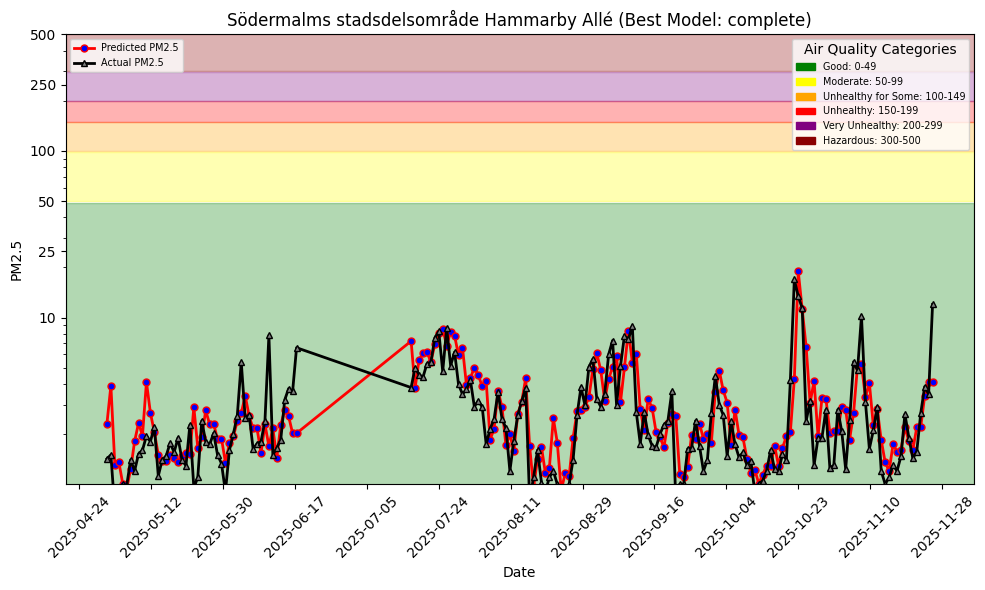

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/63637/model.json: 0.000%|      …

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/63637\images/feature_importance…

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/63637\images/forecast.png: 0.00…

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/63637\images/hindcast_predictio…

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/63637\images/hindcast_training.…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1279184/models/air_quality_xgboost_model_63637/5


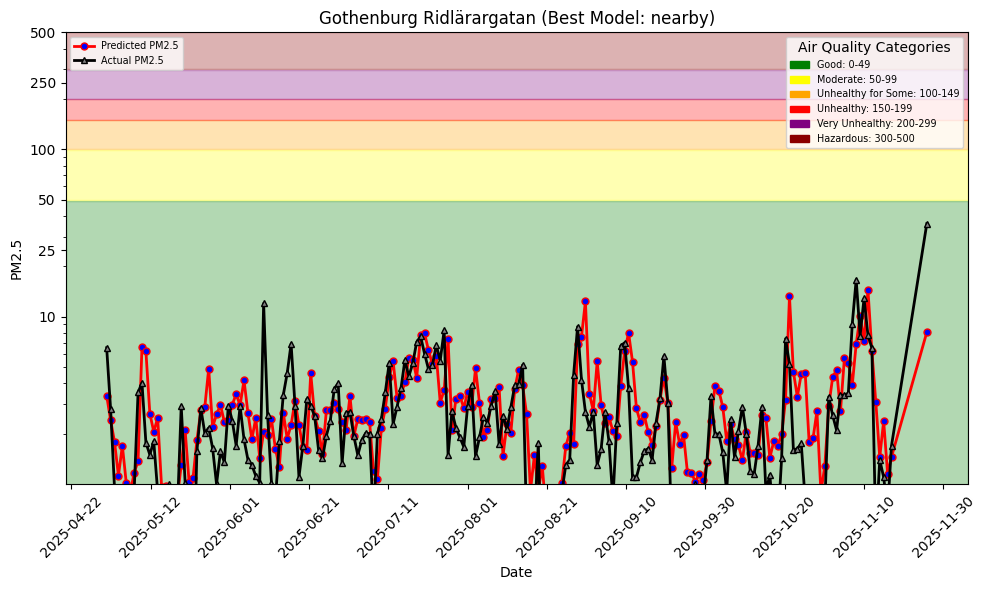

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/88372/model.json: 0.000%|      …

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/88372\images/feature_importance…

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/88372\images/forecast.png: 0.00…

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/88372\images/hindcast_predictio…

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/88372\images/hindcast_training.…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1279184/models/air_quality_xgboost_model_88372/5


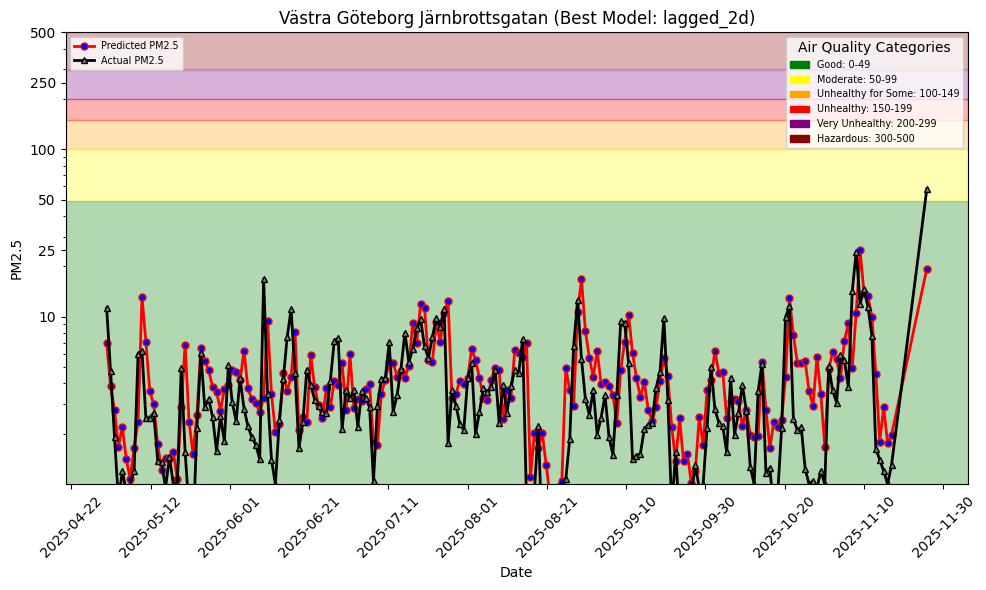

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/154549/model.json: 0.000%|     …

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/154549\images/feature_importanc…

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/154549\images/forecast.png: 0.0…

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/154549\images/hindcast_predicti…

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/154549\images/hindcast_training…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1279184/models/air_quality_xgboost_model_154549/5


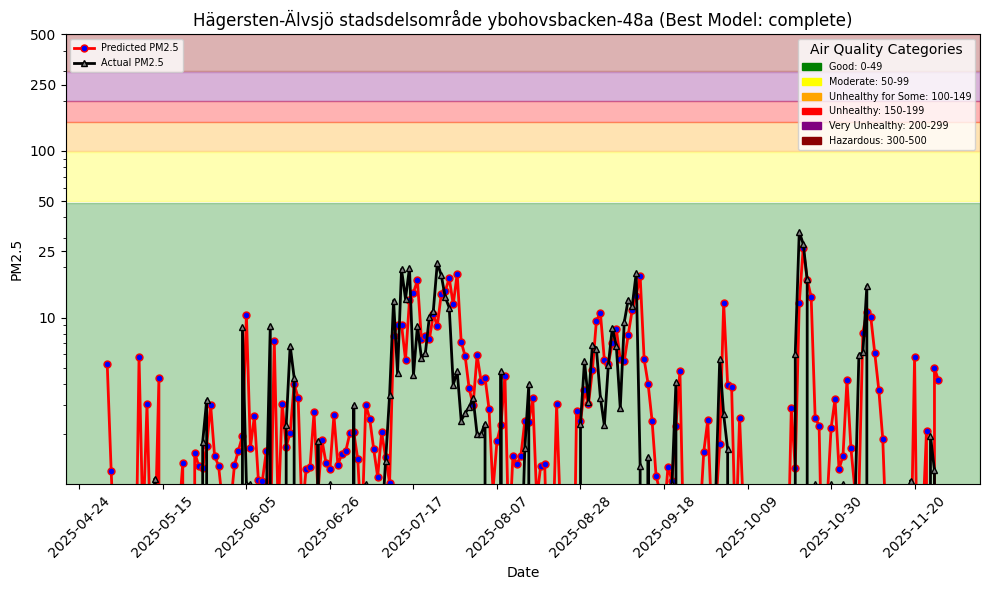

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/474841/model.json: 0.000%|     …

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/474841\images/feature_importanc…

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/474841\images/forecast.png: 0.0…

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/474841\images/hindcast_predicti…

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/474841\images/hindcast_training…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1279184/models/air_quality_xgboost_model_474841/5


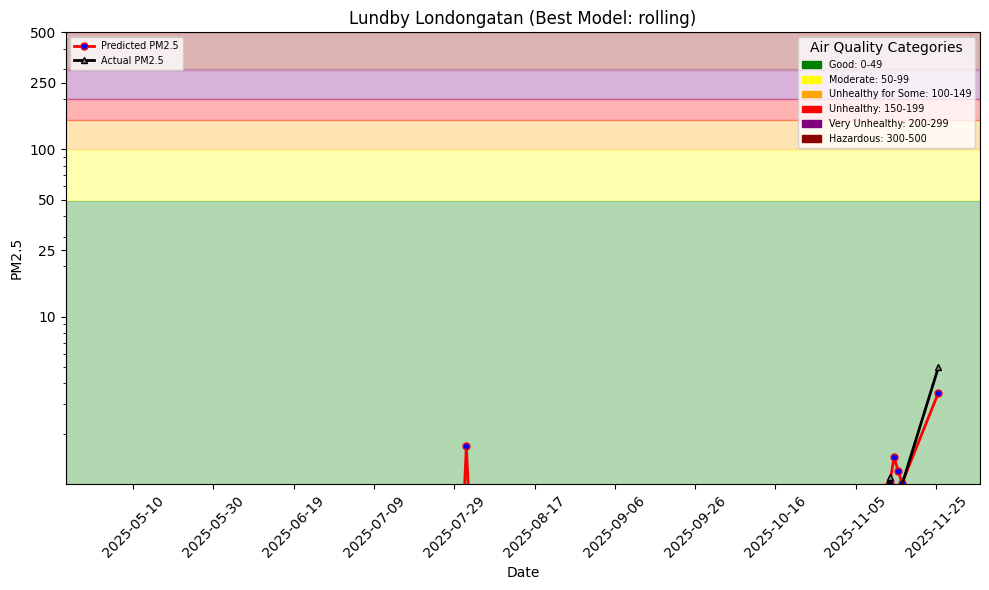

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/59893/model.json: 0.000%|      …

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/59893\images/feature_importance…

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/59893\images/forecast.png: 0.00…

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/59893\images/hindcast_predictio…

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/59893\images/hindcast_training.…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1279184/models/air_quality_xgboost_model_59893/5


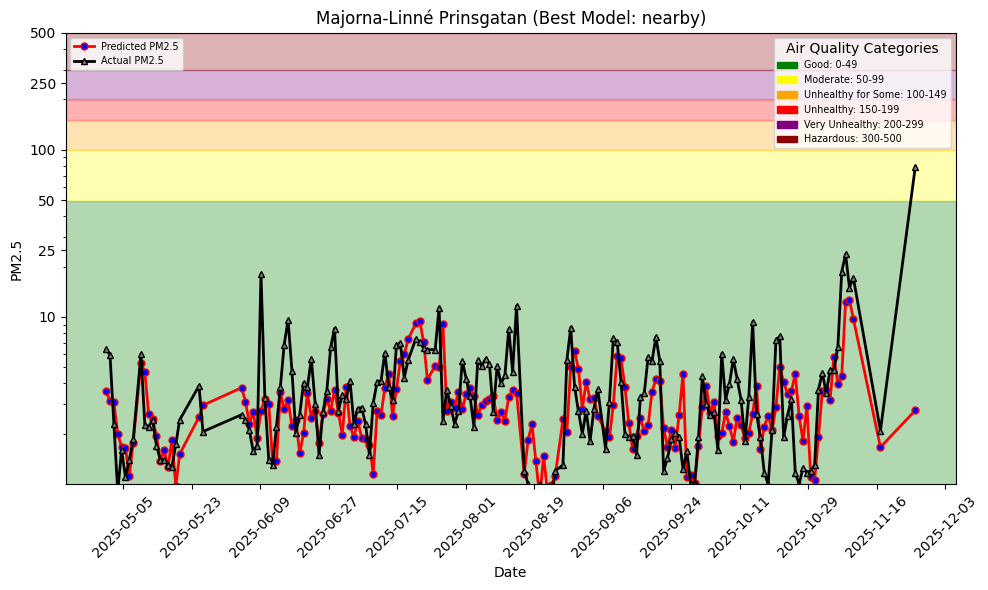

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/60541/model.json: 0.000%|      …

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/60541\images/feature_importance…

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/60541\images/forecast.png: 0.00…

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/60541\images/hindcast_predictio…

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/60541\images/hindcast_training.…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1279184/models/air_quality_xgboost_model_60541/5


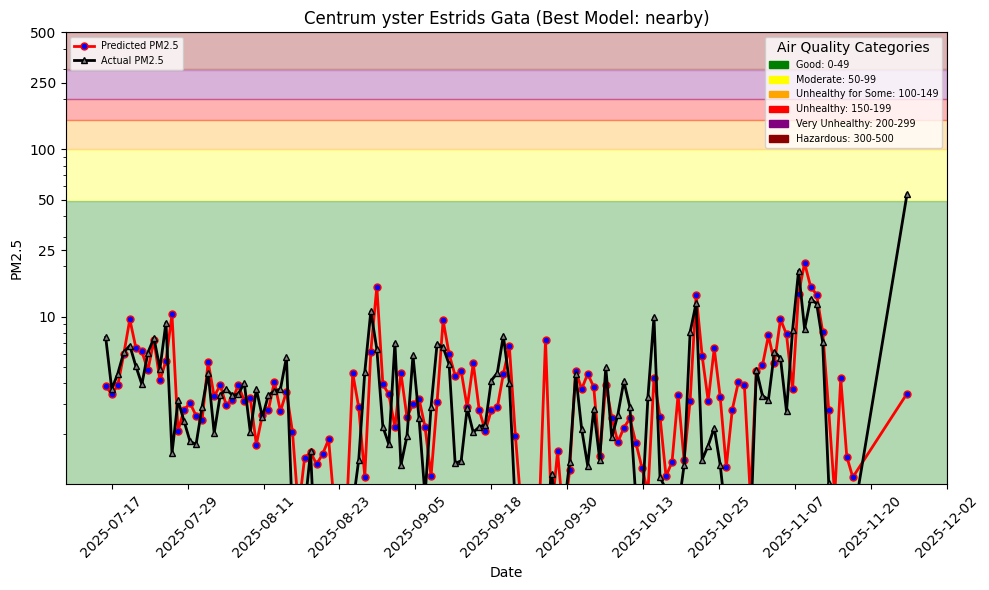

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/69628/model.json: 0.000%|      …

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/69628\images/feature_importance…

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/69628\images/forecast.png: 0.00…

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/69628\images/hindcast_predictio…

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/69628\images/hindcast_training.…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1279184/models/air_quality_xgboost_model_69628/5


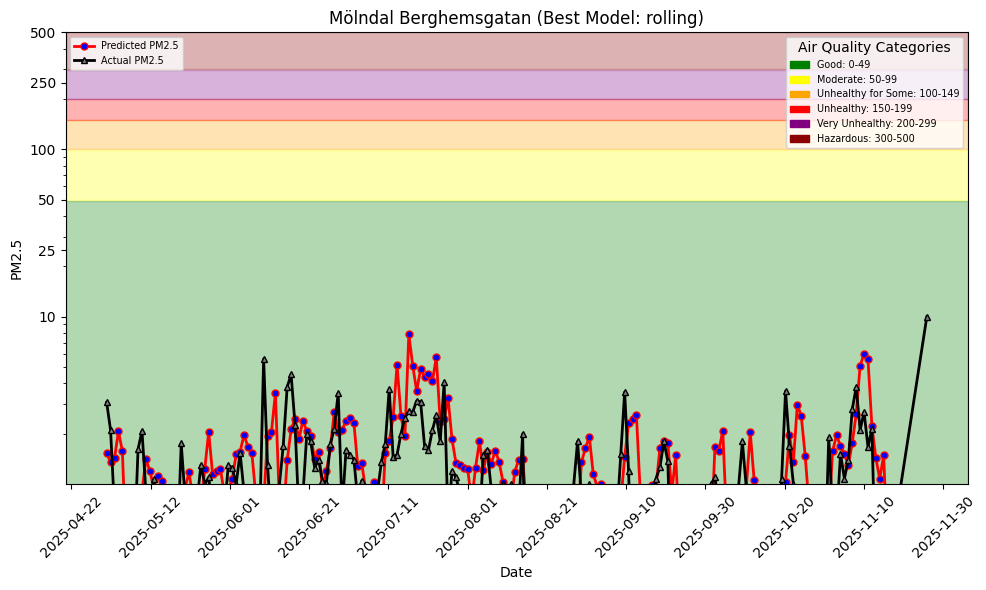

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/79750/model.json: 0.000%|      …

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/79750\images/feature_importance…

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/79750\images/forecast.png: 0.00…

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/79750\images/hindcast_predictio…

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/79750\images/hindcast_training.…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1279184/models/air_quality_xgboost_model_79750/5


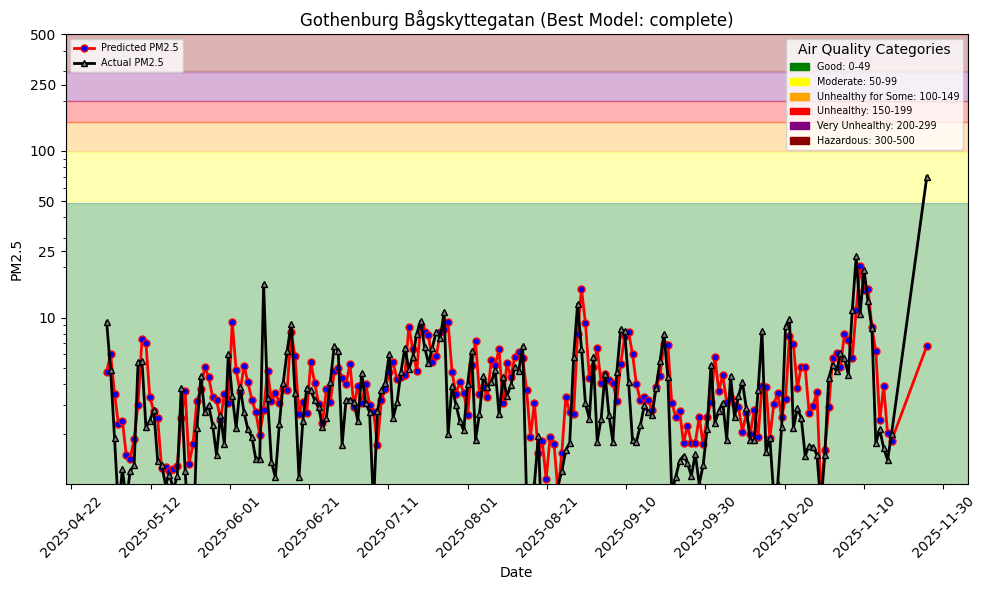

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/112672/model.json: 0.000%|     …

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/112672\images/feature_importanc…

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/112672\images/forecast.png: 0.0…

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/112672\images/hindcast_predicti…

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/112672\images/hindcast_training…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1279184/models/air_quality_xgboost_model_112672/5


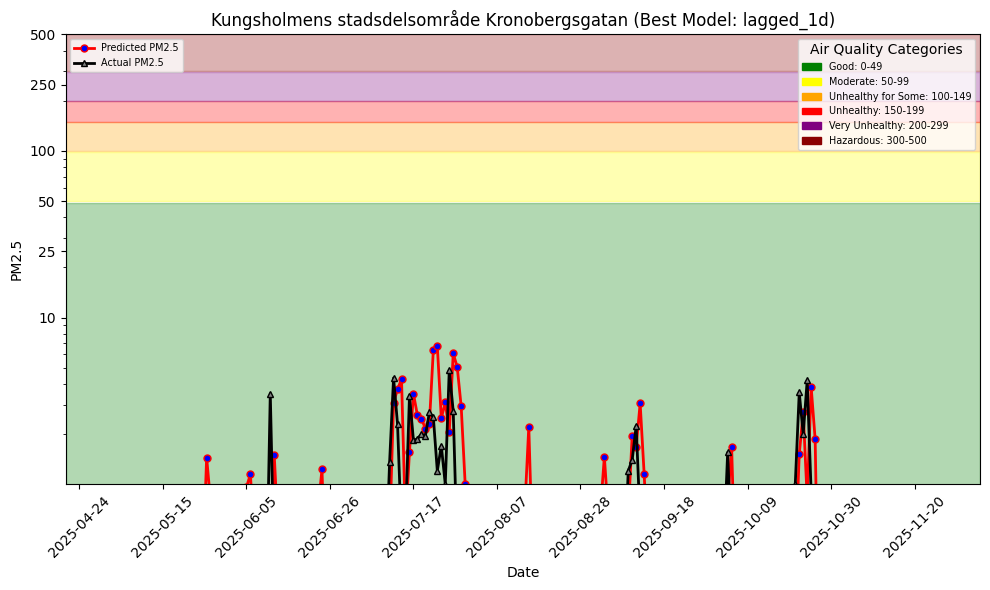

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/180187/model.json: 0.000%|     …

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/180187\images/feature_importanc…

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/180187\images/forecast.png: 0.0…

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/180187\images/hindcast_predicti…

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/180187\images/hindcast_training…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1279184/models/air_quality_xgboost_model_180187/5


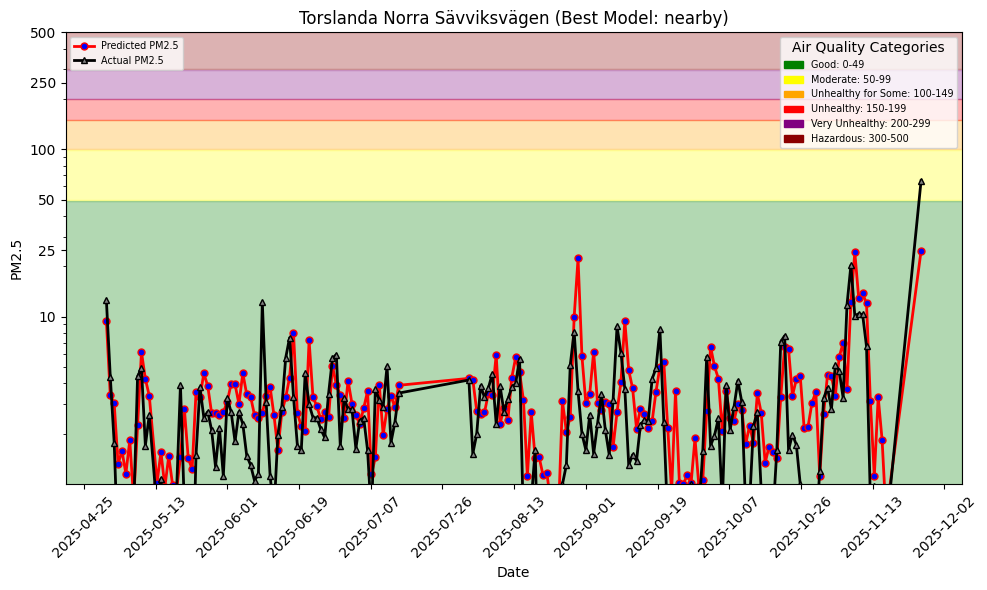

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/194215/model.json: 0.000%|     …

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/194215\images/feature_importanc…

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/194215\images/forecast.png: 0.0…

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/194215\images/hindcast_predicti…

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/194215\images/hindcast_training…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1279184/models/air_quality_xgboost_model_194215/5


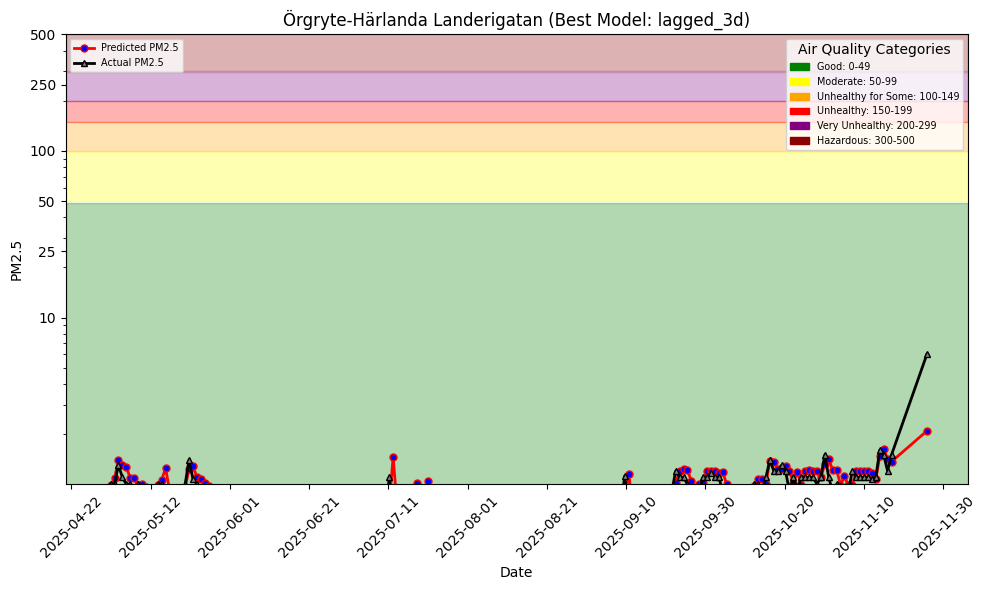

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/65146/model.json: 0.000%|      …

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/65146\images/feature_importance…

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/65146\images/forecast.png: 0.00…

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/65146\images/hindcast_predictio…

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/65146\images/hindcast_training.…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1279184/models/air_quality_xgboost_model_65146/5


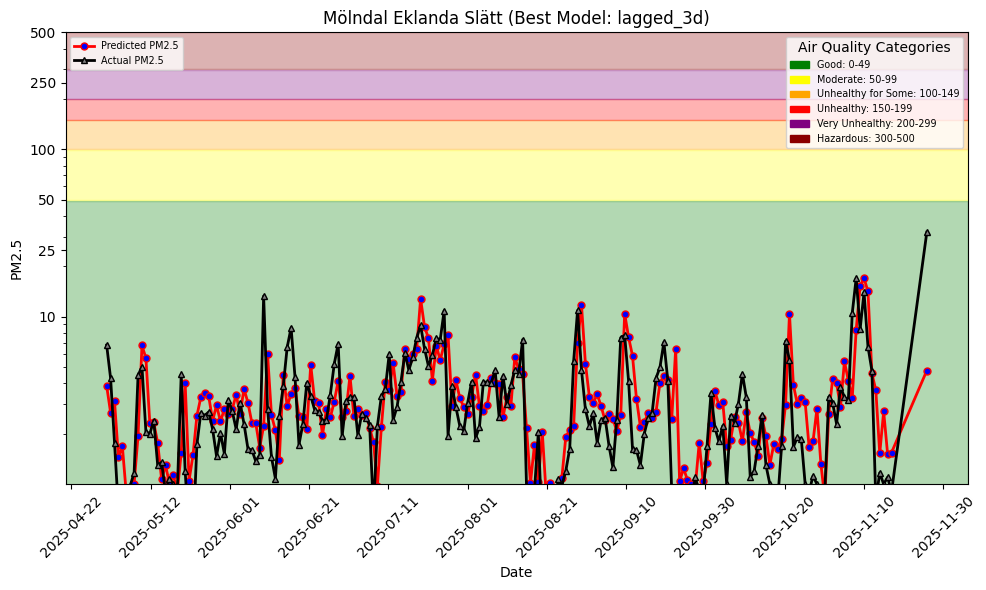

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/59095/model.json: 0.000%|      …

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/59095\images/feature_importance…

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/59095\images/forecast.png: 0.00…

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/59095\images/hindcast_predictio…

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/59095\images/hindcast_training.…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1279184/models/air_quality_xgboost_model_59095/5


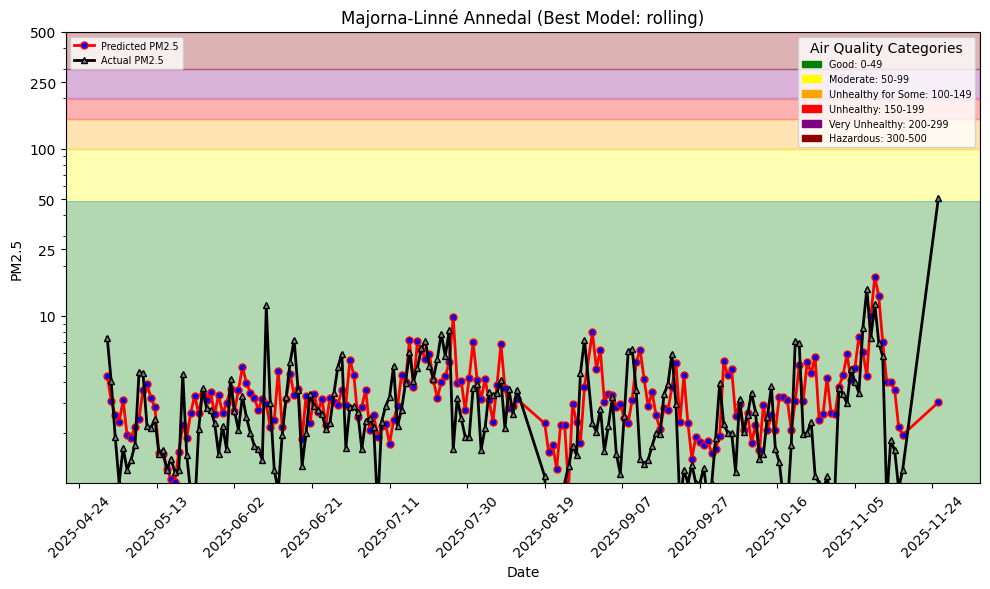

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/60535/model.json: 0.000%|      …

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/60535\images/feature_importance…

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/60535\images/forecast.png: 0.00…

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/60535\images/hindcast_predictio…

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/60535\images/hindcast_training.…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1279184/models/air_quality_xgboost_model_60535/5


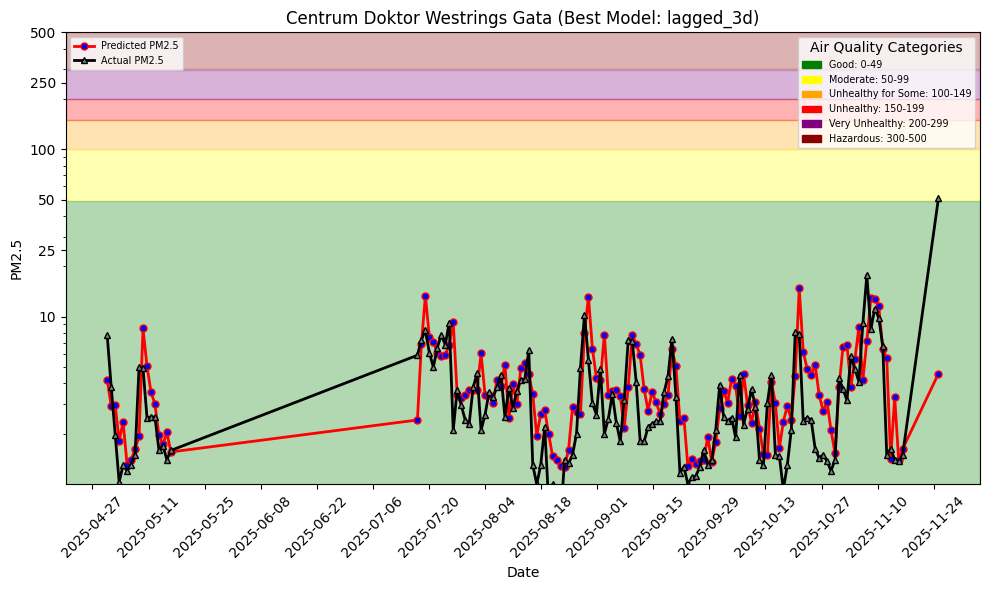

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/69724/model.json: 0.000%|      …

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/69724\images/feature_importance…

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/69724\images/forecast.png: 0.00…

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/69724\images/hindcast_predictio…

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/69724\images/hindcast_training.…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1279184/models/air_quality_xgboost_model_69724/5


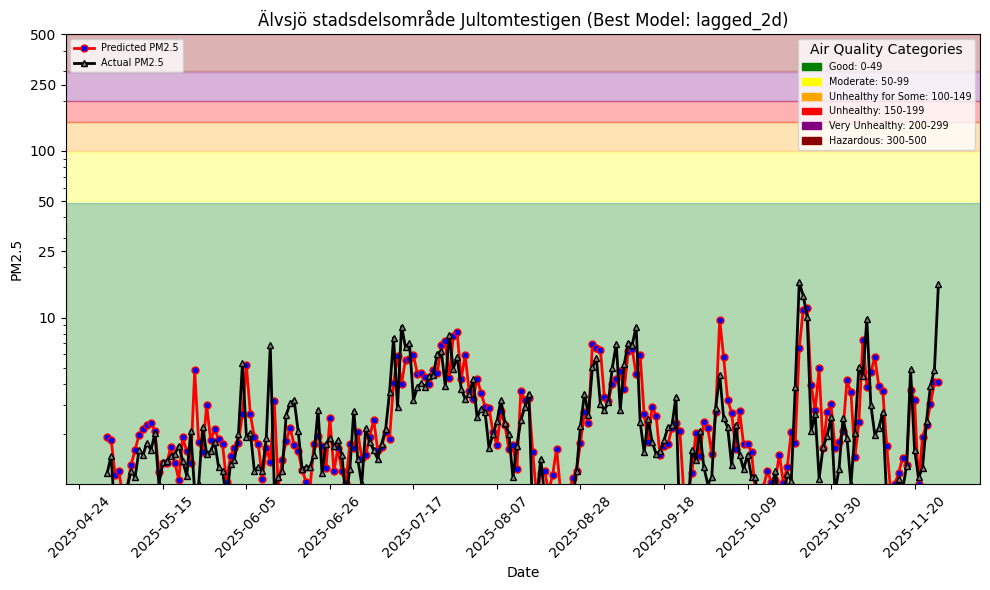

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/78529/model.json: 0.000%|      …

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/78529\images/feature_importance…

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/78529\images/forecast.png: 0.00…

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/78529\images/hindcast_predictio…

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/78529\images/hindcast_training.…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1279184/models/air_quality_xgboost_model_78529/5


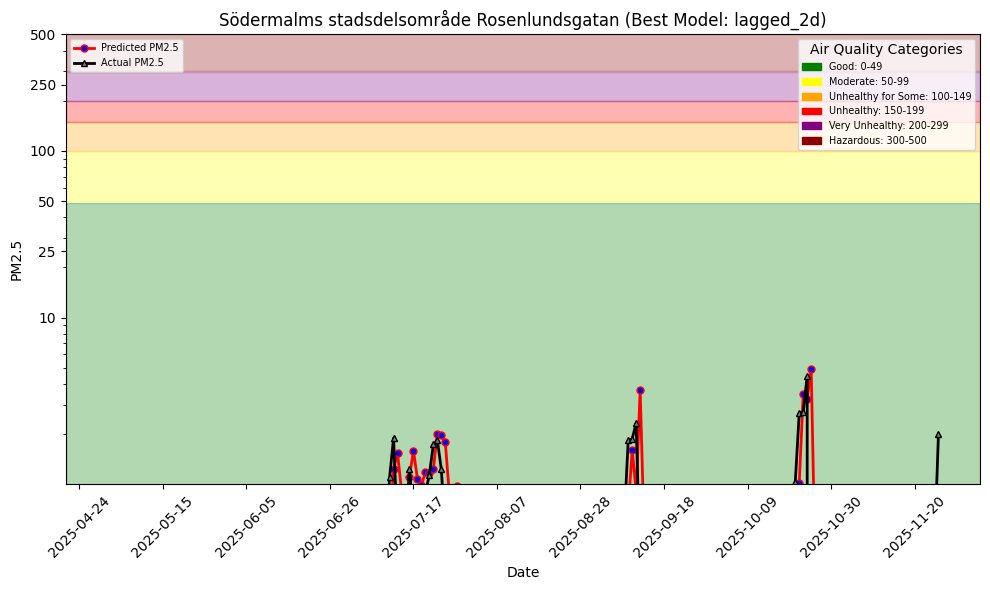

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/129124/model.json: 0.000%|     …

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/129124\images/feature_importanc…

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/129124\images/forecast.png: 0.0…

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/129124\images/hindcast_predicti…

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/129124\images/hindcast_training…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1279184/models/air_quality_xgboost_model_129124/5


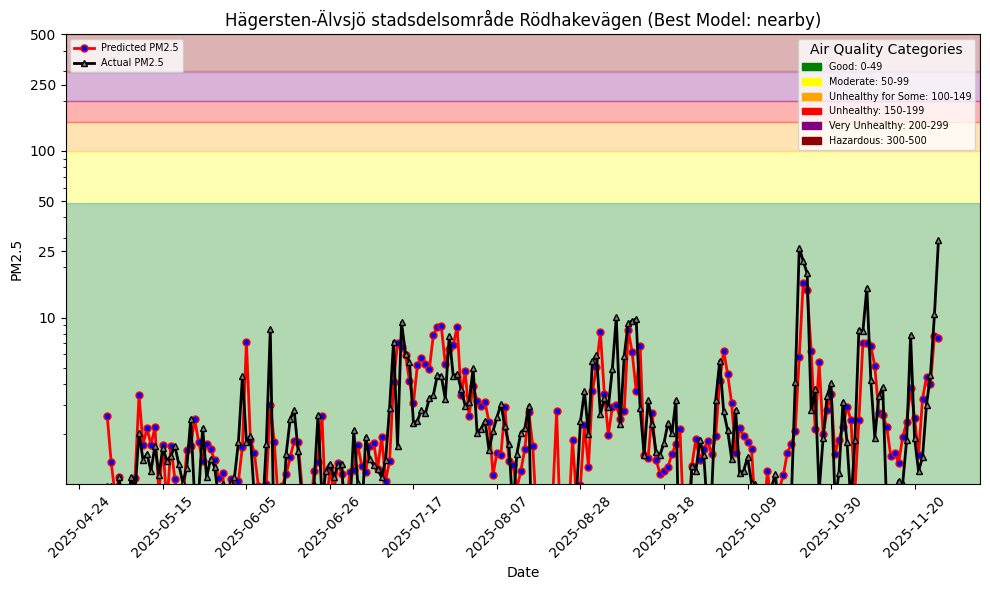

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/252352/model.json: 0.000%|     …

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/252352\images/feature_importanc…

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/252352\images/forecast.png: 0.0…

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/252352\images/hindcast_predicti…

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/252352\images/hindcast_training…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1279184/models/air_quality_xgboost_model_252352/5


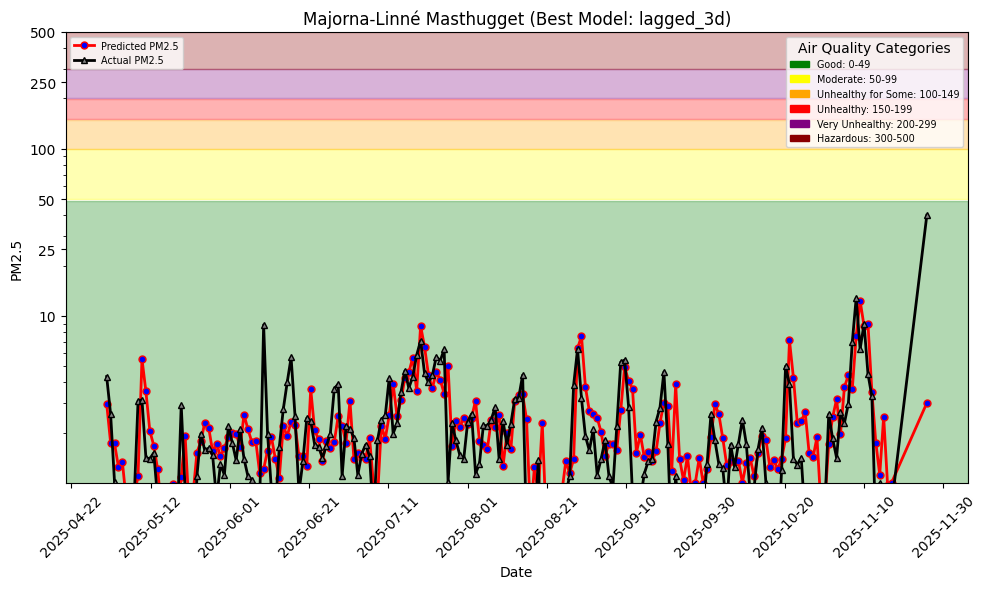

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/60853/model.json: 0.000%|      …

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/60853\images/feature_importance…

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/60853\images/forecast.png: 0.00…

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/60853\images/hindcast_predictio…

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/60853\images/hindcast_training.…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1279184/models/air_quality_xgboost_model_60853/5


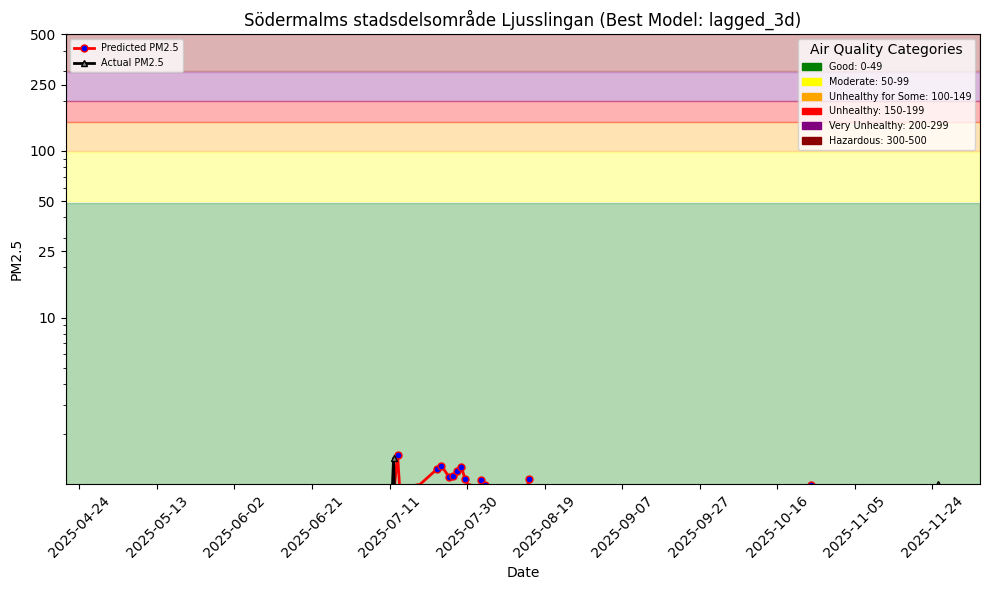

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/65272/model.json: 0.000%|      …

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/65272\images/feature_importance…

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/65272\images/forecast.png: 0.00…

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/65272\images/hindcast_predictio…

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/65272\images/hindcast_training.…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1279184/models/air_quality_xgboost_model_65272/5


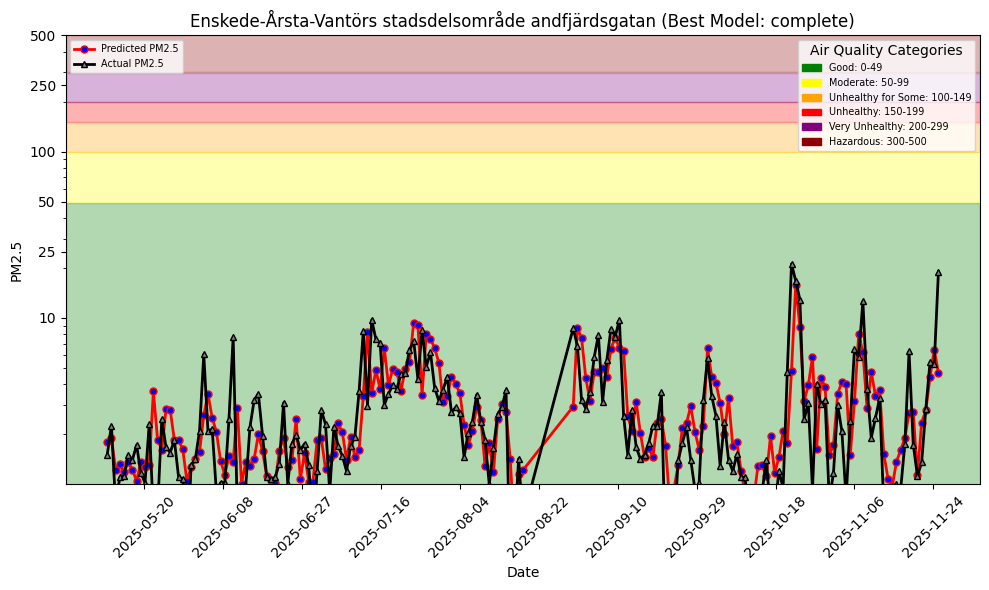

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/70564/model.json: 0.000%|      …

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/70564\images/feature_importance…

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/70564\images/forecast.png: 0.00…

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/70564\images/hindcast_predictio…

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/70564\images/hindcast_training.…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1279184/models/air_quality_xgboost_model_70564/5


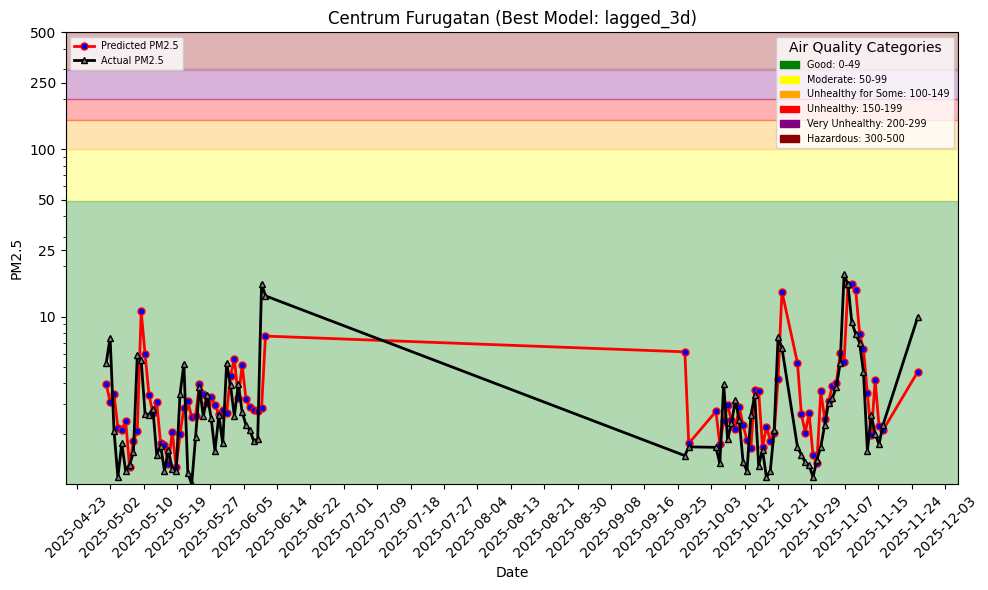

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/81505/model.json: 0.000%|      …

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/81505\images/feature_importance…

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/81505\images/forecast.png: 0.00…

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/81505\images/hindcast_predictio…

Uploading c:\Users\krist\Documents\GitHub\pm25-forecast-openmeteo-aqicn/models/81505\images/hindcast_training.…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1279184/models/air_quality_xgboost_model_81505/5


In [11]:
mr = project.get_model_registry()
df = pd.concat(all_test_data, ignore_index=True) if all_test_data else pd.DataFrame()
df = df.sort_values(by=["date"])

# Plot the best model for each sensor
for sensor_id, location in locations.items():
    city = location["city"]
    street = location["street"]
    latitude = location["latitude"]
    longitude = location["longitude"]
    
    df_subset = df[(df["latitude"] == latitude) & (df["longitude"] == longitude)].copy()
    if len(df_subset) == 0:
        continue
    
    # Get the best model name for display
    best_model_name = df_subset['best_model'].iloc[0] if 'best_model' in df_subset.columns else 'unknown'
    best_model_r2 = df_subset['R2'].iloc[0] if 'R2' in df_subset.columns else 0
    best_model_mse = df_subset['MSE'].iloc[0] if 'MSE' in df_subset.columns else 0
    best_model_feature_view = feature_views[best_model_name]
    
    df_subset = df_subset.sort_values(by=["date"])
    df_subset = df_subset.drop(columns=["latitude", "longitude", "best_model"])
    
    images_dir = f"{model_dir}/{sensor_id}/images"
    image_path = f"{images_dir}/hindcast_training.png"
    
    plt = airquality.plot_air_quality_forecast(
        city, street, df_subset, image_path, hindcast=True
    )
    plt.title(f"{city} {street} (Best Model: {best_model_name})")
    plt.show()

    # airquality.delete_models(mr, f"air_quality_xgboost_model_{sensor_id}")
    aq_model = mr.python.create_model(
        name=f"air_quality_xgboost_model_{sensor_id}",
        metrics={
            "R2": best_model_r2,
            "MSE": best_model_mse,
        },
        feature_view=best_model_feature_view,
        description=f"Air Quality (PM2.5) predictor for {city} {street} using {best_model_name} configuration",
    )

    aq_model.save(f"{model_dir}/{sensor_id}")
